In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import pickle
import os
from scipy.stats import chisquare
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
from collections import Counter
from logbin230119 import logbin
from BANetwork import Network

In [8]:
# Settings for matplotlib
params = { 'axes.labelsize': 14,
           'axes.titlesize': 14,
           'xtick.labelsize': 12,
           'ytick.labelsize': 12,
           'figure.figsize': [9, 4],
           'figure.dpi': 150,
           'figure.titlesize': 14,
           'grid.linewidth':0.5, 
           'legend.fontsize': 10}
plt.rcParams.update(params)

### Check programme
Fat tails are observed as expected for preferential, and a sharp logarithmic for random.

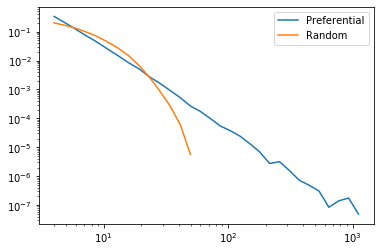

In [2]:
pref = Network(4, 'preferential').add_vertices(1e5).count_deg()
rand = Network(4, 'random').add_vertices(1e5).count_deg()
x_p, y_p = logbin(pref.degree, scale=1.2, zeros=False)
x_r, y_r = logbin(rand.degree, scale=1.2, zeros=False)
plt.loglog(x_p, y_p, label='Preferential')
plt.loglog(x_r, y_r, label='Random')
plt.legend()
plt.show()

### Data Generation

In [61]:
def generate_data(model, a, m, N):
    data = []
    for i in range(a):
        network = Network(m, model)
        network.add_vertices(N).count_deg()
        data.append(network.degree)
    return data

In [187]:
# Varying m
a = 10 # Number of repeated simulations for each model
m_ = [1, 2, 4, 8, 16, 32]
N = 6 # Max number of vertices is 1eN
models = ['preferential', 'random']
for model in models:
    for m in m_:
        data = generate_data(model, a, m, 10**N)
        pickle.dump(data, open('data/{}_{}_{}_{}.p'.format(model, m, a, N), 'wb'))
        print('saved {} {}'.format(model, m))

saved preferential 1
saved preferential 2
saved preferential 4
saved preferential 8
saved preferential 16
saved preferential 32
saved random 1
saved random 2
saved random 4
saved random 8
saved random 16
saved random 32


In [71]:
# Varying N
N_ = [2, 3, 4, 5] # N = 10**n 
a_ = np.subtract(7, N_)
m = 4
models = ['preferential', 'random']
for model in models:
    for a, N in zip(a_, N_):
        data = generate_data(model, int(10**a), int(m), int(10**N))
        pickle.dump(data, open('data/{}_{}_{}_{}.p'.format(model, m, a, N), 'wb'))
        print('saved {} {}'.format(model, m))

saved preferential 4
saved preferential 4
saved preferential 4
saved preferential 4
saved random 4
saved random 4
saved random 4
saved random 4


In [70]:
np.subtract(8, [2, 3])

array([6, 5])

### Load data

In [3]:
def load_data(path):
    raw_data = pickle.load(open(path, 'rb'))
    data = [v for i in raw_data for v in i]
    return data

In [4]:
m_ = [1, 2, 4, 8, 16, 32]
N = 6
pref_models = {}
rand_models = {}
for file in os.listdir('data'):
    if ('pref' in file) and ('6' in file.split('_')[-1]):
        m = file.split('_')[1]
        pref_models[m] = load_data('data/{}'.format(file))
    if ('rand' in file) and ('6' in file.split('_')[-1]):
        m = file.split('_')[1]
        rand_models[m] = load_data('data/{}'.format(file))

### Effect of Log-binning

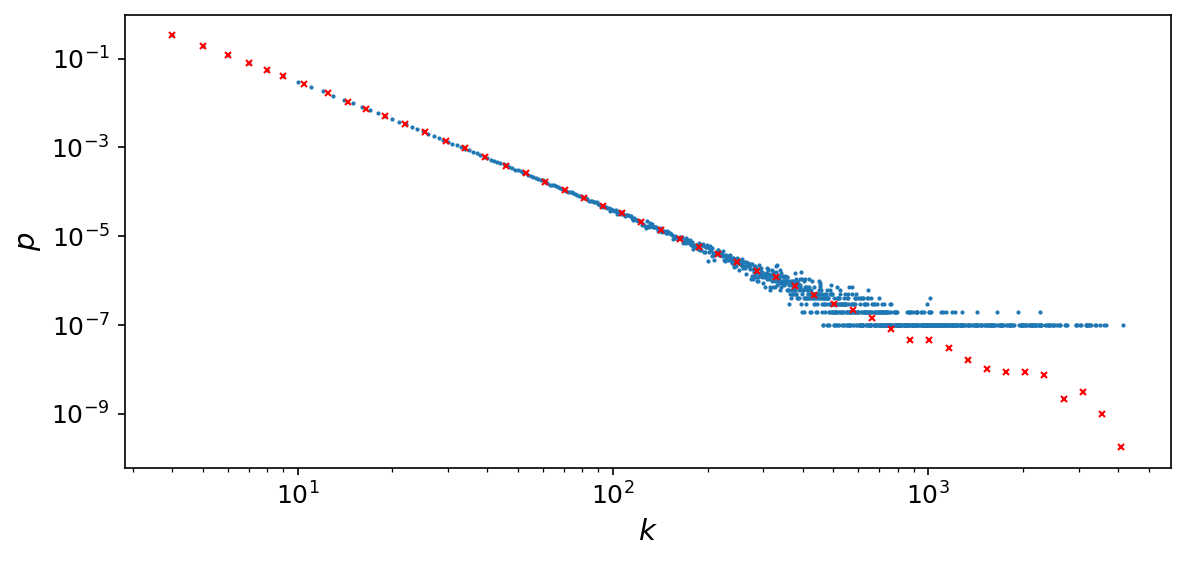

In [53]:
pref_4 = pref_models['4']
pref_4_freq = dict(Counter(pref_4))
x = list(pref_4_freq.keys())
y = list(pref_4_freq.values())
x_bin, y_bin = logbin(pref_4, scale=1.15)
y = np.divide(y, sum(y))
plt.loglog(x, y, lw=0, marker='o', ms=1, label='raw')
plt.loglog(x_bin, y_bin, lw=0, marker='x', ms=2.5, label='log-binned', color='red')
plt.xlabel('$k$')
plt.ylabel('$p$')
plt.savefig('img/log_bin.pdf', bbox_inches='tight')

### Theoretical Model

In [5]:
def p_discrete(k, m):
    m = int(m)
    return 2 * m * (m+1) / (k * (k+1) * (k+2))

def p_cont(k, m):
    m = int(m)
    return m**2 * np.power(k, -3) / 4

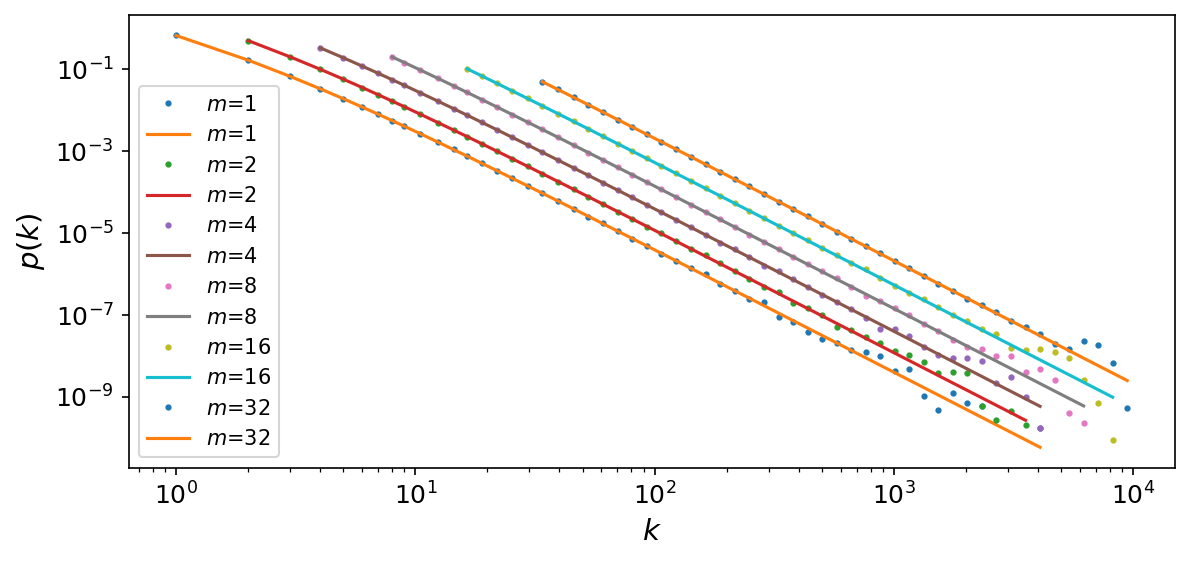

In [31]:
for m in m_:
    x, y = logbin(pref_models[str(m)], scale=1.15)
    plt.loglog(x, y, label='$m$={}'.format(m), lw=0, ms=2, marker='o')
    plt.loglog(x, p_discrete(x, m), label='$m$={}'.format(m))
#plt.xlim(0, 1e3)
#plt.ylim(1e-10, 1e2)
plt.xlabel('$k$')
plt.ylabel('$p(k)$')
plt.legend()
plt.savefig('img/fit_theory.pdf', bbox_inches='tight')

### Goodness of fit

In [35]:
for m in m_:
    x, y = logbin(pref_models[str(m)], scale=1.15)
    x = x[:-10]
    y = y[:-10]
    y_t = p_discrete(x, m)
    chi_ = chisquare(y, y_t)
    print(chi_)

Power_divergenceResult(statistic=2.3617152934108123e-06, pvalue=1.0)
Power_divergenceResult(statistic=2.091246770580286e-06, pvalue=1.0)
Power_divergenceResult(statistic=3.1547494406049126e-06, pvalue=1.0)
Power_divergenceResult(statistic=1.142204612112094e-05, pvalue=1.0)
Power_divergenceResult(statistic=7.248021656025862e-06, pvalue=1.0)
Power_divergenceResult(statistic=2.795817290024018e-06, pvalue=1.0)


### Largest degree

In [85]:
# Load data
m = 4
N_ = [2, 3, 4, 5, 6]
pref_models_N = {}
rand_models_N = {}
for file in os.listdir('data'):
    if ('pref' in file) and (str(m) in file.split('_')[1]):
        N = file.split('_')[-1][-3:-2]
        pref_models_N[N] = pickle.load(open('data/{}'.format(file), 'rb'))
    if ('rand' in file) and (str(m) in file.split('_')[1]):
        N = file.split('_')[-1][-3:-2]
        rand_models_N[N] = pickle.load(open('data/{}'.format(file), 'rb'))

In [111]:
pref_models_max = {}
k_max = []
k_max_std = []
for N in N_:
    N_max = [max(graph) for graph in pref_models_N[str(N)]]
    pref_models_max[N] = N_max
    k_max.append(np.mean(N_max))
    k_max_std.append(np.std(N_max))

def linear(x, a, b):
    return a * x + b

(array([0.49518162, 1.28434894]),
 [0.0043787096695345066, 0.042775794893018484])

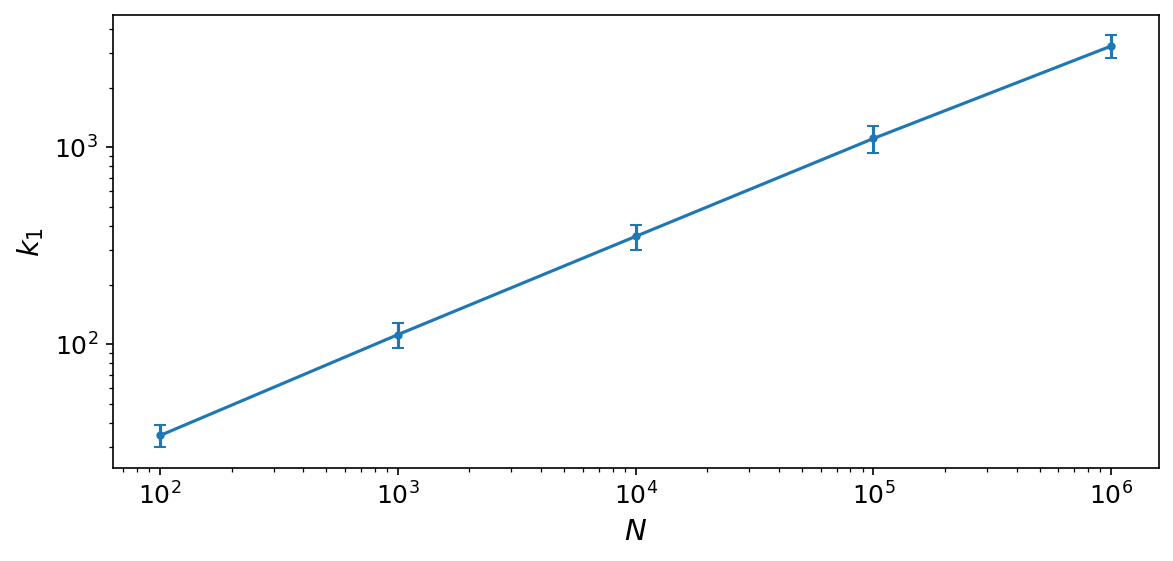

In [140]:
x = np.power(10, N_)
plt.errorbar(x, k_max, yerr=k_max_std, marker='o', ms=3, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$N$')
plt.ylabel('$k_1$')
plt.savefig('k_max_N.pdf', bbox_inches='tight')

popt, pcov = curve_fit(linear, np.log(x), np.log(k_max))
err = [np.sqrt(pcov[i,i]) for i in range(len(popt))]
popt, err

In [ ]:
pref_models_N_all = {}
for n in list(pref_models_N):
    pref_models_N_all[n] = [i for j in pref_models_N[n] for i in j]

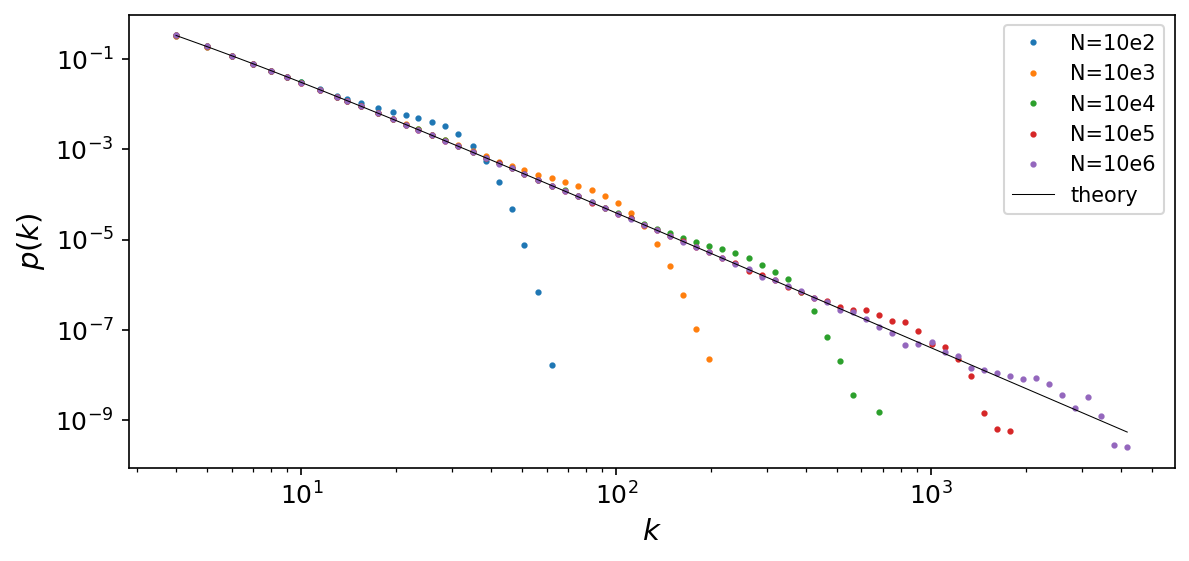

In [162]:
for n in range(2, 7):
    x, y = logbin(pref_models_N_all[str(n)], scale=1.1)
    plt.loglog(x, y, label='N=10e{}'.format(n), marker='o', lw=0, ms=2)
plt.loglog(x, p_discrete(x, 4), linestyle='-', lw=0.5, label='theory', color='black')
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$p(k)$')
plt.savefig('pref_N.pdf', bbox_inches='tight')

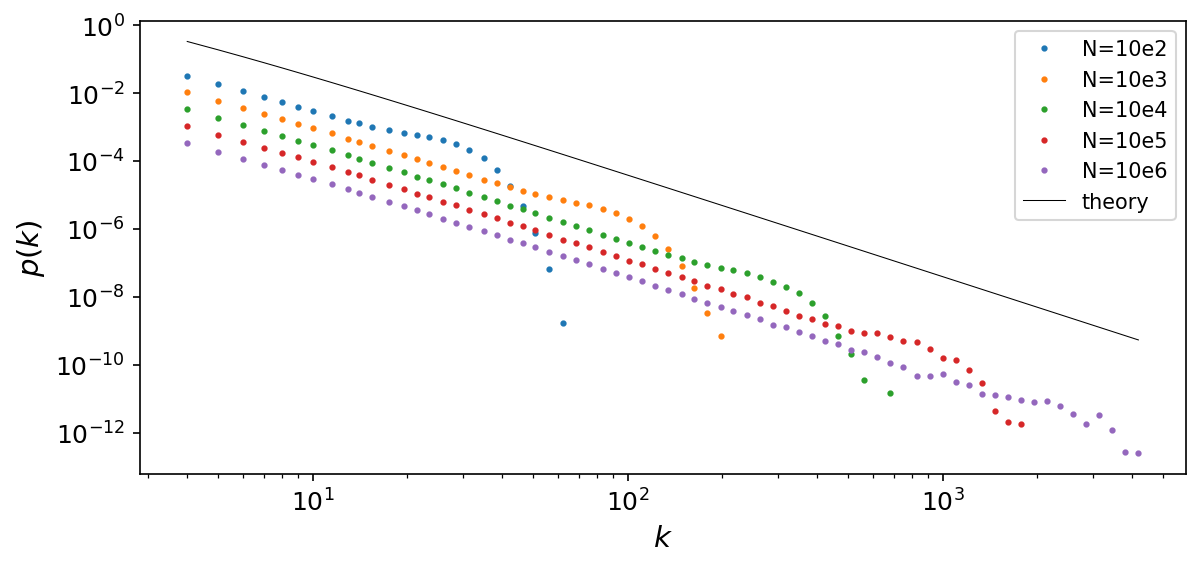

In [164]:
# Data Collapse
for n in range(2, 7):
    x, y = logbin(pref_models_N_all[str(n)], scale=1.1)
    y = np.divide(y, np.sqrt(np.power(10, n)))
    plt.loglog(x, y, label='N=10e{}'.format(n), marker='o', lw=0, ms=2)
#plt.loglog(x, p_discrete(x, 4), linestyle='-', lw=0.5, label='theory', color='black')
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$p(k)$')
plt.savefig('pref_N_collapse.pdf', bbox_inches='tight')

## Pure Random Attachment
### Degree Distribution